# <center> Topic Modeling </center>

- This lecture is created based on 
    * Blei. D. (2012), "Probabilistic Topic Models", http://www.cs.columbia.edu/~blei/talks/Blei_ICML_2012.pdf
    * http://videolectures.net/mlss09uk_blei_tm/
    
- An intuitive explanation of LDA: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

## 1. Introduction

- Topic modeling provides methods for automatically organizing, understanding, searching, and summarizing large electronic archives.
  - Discover the hidden themes that pervade the collection.
  - Annotate the documents according to those themes.
  - Use annotations to organize, summarize, and search the texts.
  
<img src='topic_modeling.png' width='70%'>

- Formal Definitions

  - **Topics**: each topic is a `distribution over words` 
    - e.g. for topic "Gentics", $p('gene'~|~'Genetics')~=~0.04$, $p('dna'~|~'Genetics')=0.02$, ...
    - e.g. for topic "NeuroScience", $p('brain'~|~'NeuroScience')~=~0.04$, $p('gene'~|~'NeuroScience')=0.001$, ...
    - $K$ topics $\theta_1, \theta_2, ..., \theta_K$, $N$ words $w_1, w_2, ..., w_N$ in corpus, we need to know  $p(w_i|\theta_j)$ for $i \in N$ and $j\in K$ <br><br>
    
  - **Document ($d$)**: a `mixture of topics`
    - e.g. for above document $d$, $p('Genetics'~|~d)=0.5$, $p('LifeScience'~|~d)=0.15$, ...
    - In general, given document $d$ and topic $\theta_j$, we need to know $p(\theta_j~|~d)$, i.e. `topic proportion`
    
    
- Topic models are also referred to as language models



- Probabilities $p(w_i~|~\theta_j)$ and $p(\theta_j~|~d)$ are **hidden structures** to be discovered, a.k.a **latent variables**

<img src='latent_structure.png' width='70%' style="float: left;">
  


## 2. Latent Dirichlet Allocation (LDA)

### 2.1 Dirichlet Distribution

- **Dirichlet** $Dir(\alpha)$ : is a probability distribution with parameter $\alpha$ to `generate another distribution`, say $\theta$ 
  - e.g. with $\alpha = {α_1,α_2,α_3}$, $Dir(\alpha)$ generates ${ \theta_1,\theta_2,\theta_3}$, where $\theta_1+\theta_2+\theta_3 =1$ . 
  - $E(\theta_i) = \frac{\alpha_i}{\sum_j{\alpha_j}}$, i.e. the larger $\alpha_i$, the larger the $\theta_i$, or component $i$ is more likely to happen. 
  - In LDA, usually $α_1=α_2=α_3=...=\frac{1}{K}$, where $K$ is the number of topics.
  - For details of Dirichlet function, check videos e.g. https://www.youtube.com/watch?v=nfBNOWv1pgE 

<img src='dirichlet.svg' width="25%" height="15%">


- Visualize Dirichlet Distributions (code is taken from https://gist.github.com/tboggs/8778945)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_AREA = 0.5 * 1 * 0.75**0.5
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

# For each corner of the triangle, the pair of other corners
_pairs = [_corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    coords = np.array([tri_area(xy, p) for p in _pairs]) / _AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                                for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)

$\alpha = (1, 1, 1)$: $\theta_1, \theta_2,\theta_3 $ are evenly distributed

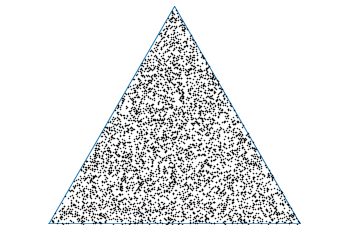

In [29]:
# symmetric alpha
alpha = [1, 1, 1]
dist = Dirichlet(alpha)
plot_points(dist.sample(5000))

$\alpha = (1, 2, 3)$: The dense area moves awary from $\theta_1$ 

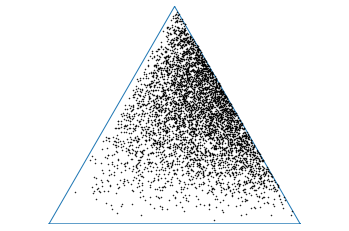

In [3]:
alpha = [1, 2, 3]
dist = Dirichlet(alpha)
plot_points(dist.sample(5000))

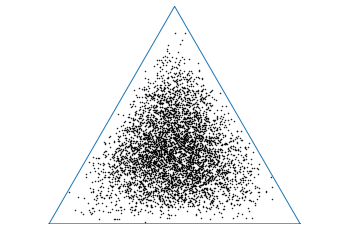

In [20]:
alpha = [3, 3, 3]
dist = Dirichlet(alpha)
plot_points(dist.sample(5000))

$\alpha = (1/3, 1/3, 1/3)$: Points are densely distributed along the edge 
- `Sparsity`: Some component gets 0 probability

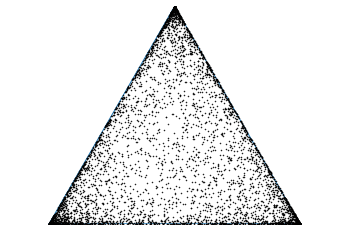

In [4]:
alpha = [1/3, 1/3, 1/3]
dist = Dirichlet(alpha)
plot_points(dist.sample(5000))

### 2.2 Generative Model
- A generative model which generates a document $\mathbf{w}=[w_1, w_2, ...]$ as follows:

    - (1) Choose topic mixture $\theta \sim Dir~(\alpha)$
        - For example, assume three topics: `Genetics` $(\theta_1)$, `NeuroScience`$(\theta_2)$, `Computation`$(\theta_3)$
        - After sampling, $\theta = [0.5, 0.3, 0.2]$, i.e., 
            - 50% of the content is about `Genetics`, 
            - 30% of the content is about `NeuroScience`,
            - 20% of the content is about `Computation`
        - Note the topic mixture is controled by $alpha$ in the `Dirichlet distribution`<br><br>
    - (2) For each of the $N$ words:
        - (a) Choose a topic assignment $z_n$. Let $p~(z_n = \theta_j~|~\theta)$ denote the probability of choosing $\theta_j$.
            - For the above example,
                - $p~(z_n = Genetics~|~\theta) = 0.5$, i.e. 50% chance $w_n$ belongs to topic $\theta_1$
                - $p~(z_n = NeuroScience~|~\theta) = 0.3$, i.e. 30% chance $w_n$ belongs to topic $\theta_2$
                - $p~(z_n = Computation~|~\theta) = 0.2$, i.e. 20% chance $w_n$ belongs to topic $\theta_3$<br><br>
        
        - (b) Choose a word $w_n$ from the chosen topic $\theta_j$. Let $\beta $ denote the word distribution per topic. 
            - $\beta$ is a  $N \times K$ matrix, i.e. the probability of each word belonging to a topic, where $K$ is the number of topics
            - e.g. the given $z_n = Genetics$, $p~(w_n=gene) = 0.04$
            - $p~(w_n~|~\theta, \beta) = \sum_{z_n}{p~(z_n~|~\theta) * p~(w_n~|~z_n, \beta)}$
             



- This generative process can be visualized as follows:
<img src = 'lda.png' width='50%'>

- Then for an document $\mathbf{w}=[w_1, w_2, ...]$, $p(\mathbf{w} | \alpha, \beta)$ can be calculated as follows:
<img src = 'formula.png' width='50%'>

- We can tune $\alpha, \beta$ such that $p(\mathbf{w} | \alpha, \beta)$ is maximized

### 2.3. LDA Parameter Fitting
- Common techniques to estimate these probabilities are Variational Bayesian inference, Collapsed Gibbs Sampling (See Blei's paper for details)
  - Collapsed Gibbs Sampling: https://www.youtube.com/watch?v=u7l5hhmdc0M
    1. Randomly assign each word in each sample to a topic 
    2. Iteratively update the assignment of each word

<img src="gibbs_sampling.png" width="50%" style="float: left;">



### 2.3. Evaluate Topic Model - Perplexity
- For a single document $d$ with $N_d$ words, denoted as $\textbf{W}_d = \{w_1, w_2, ..., w_{N_d}\}$,  <br>
$ 
   \begin{align}
  perplexity~(d) &= exp~({H(d)}),\\
  H(d) &= - \frac{ln~(p~(\textbf{W}_d))}{N_d}\\
  \end{align}  
$
- $p(\textbf{W}_d)$, the probability of seeing a document $d$, can be calculated based on:
   - word distribution per topic, i.e. $p~(w_i~|~\theta_j)$, and 
   - topic mixture, i.e. $p~(\theta_j~|~d)$
- For a test set of D with M documents <br>
$ 
   \begin{align}
   perplexity~(d) &= exp~({H(D)}), \\
   H(D) &= - \frac{\sum_{d \in D} {ln~(p~(\textbf{W}_d)})}{\sum_{d \in D}{N_d}} 
   \end{align} 
   $
- Intutition: 
  - A lower perplexity score indicates better generalization performance
  - Minimizing H(d) is equivalent to maximizing log likelihood
- To evaluate a topic model, calcuate perplexity on **testing dataset** (i.e. evaluating how generaalized the model is)
- Note: if you have some labeled data, you should also conduct **external evaluation**, i.e. 
  - map each topic to a labeled class, 
  - compute precision/recall from the labeled data

## 3. Experiement with LDA
- A few libraries available for LDA: gensim, lda, sklearn
- We use sklearn and gensim here 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd

In [2]:
# Exercise 3.1. Load yahoo multi-label data set
import json
from numpy.random import shuffle

data=json.load(open('ydata.json','r'))

# shuffle the data
shuffle(data)

text,label=zip(*data)
text=list(text)
label=list(label)

print(text[0])
print(label[0])

alabama sues bp for catastrophic gulf oil spillbyline by verna gatestime fri aug pm et birmingham alabama reuters alabama is suing bp plc transocean and halliburton for catastrophic harm caused by the gulf of mexico oil spill the state s attorney general said on friday alabama is the first state to sue bp for damage from the world s worst offshore oil spill the decision stems from fear economic victims will be inadequately compensated and bp will shirk its financial responsibility attorney general troy king said we are making this claim because we believe that bp has inflicted catastrophic harm on the state we are suing them for the amount it will take to make alabama whole king told reuters declining to specify a figure for damages bp had no immediate comment a company spokeswoman said the suit also named anadarko petroleum corp among others transocean owned the doomed deepwater horizon drilling rig that was hired by bp and exploded and sank in april triggering the oil spill halliburt

In [3]:
# Exercise 3.2. Preprocessing - Create Term Frequency Matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Let's remove domain specific stop words like 'said'
from nltk.corpus import stopwords
stop = list(stopwords.words('english')) + ['said']

# LDA can only use raw term counts for LDA 
tf_vectorizer = CountVectorizer(min_df=5, stop_words=stop)
tf = tf_vectorizer.fit_transform(text)

# each feature is a word (bag of words)
# get_feature_names() gives all words
tf_feature_names = tf_vectorizer.get_feature_names()

print(tf_feature_names[0:10])
print(tf.shape)

# split dataset into train (90%) and test sets (10%)
# the test sets will be used to evaluate proplexity of topic modeling
X_train, X_test = train_test_split(\
                tf, test_size=0.1, random_state=0)

['aa', 'aaa', 'aah', 'aap', 'aapl', 'aaron', 'aazpeitia', 'ab', 'aba', 'abandon']
(6426, 18173)


In [4]:
# Exercise 3.3. Train LDA model
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 4

# Run LDA. For details, check
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation.perplexity

# max_iter control the number of iterations 
# evaluate_every determines how often the perplexity is calculated
# n_jobs is the number of parallel threads
lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=30,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)

iteration: 1 of max_iter: 30, perplexity: 4669.0525
iteration: 2 of max_iter: 30, perplexity: 4093.9589
iteration: 3 of max_iter: 30, perplexity: 3800.8443
iteration: 4 of max_iter: 30, perplexity: 3662.6258
iteration: 5 of max_iter: 30, perplexity: 3591.6997
iteration: 6 of max_iter: 30, perplexity: 3549.2615
iteration: 7 of max_iter: 30, perplexity: 3516.9232
iteration: 8 of max_iter: 30, perplexity: 3488.9491
iteration: 9 of max_iter: 30, perplexity: 3462.1018
iteration: 10 of max_iter: 30, perplexity: 3436.0877
iteration: 11 of max_iter: 30, perplexity: 3412.6733
iteration: 12 of max_iter: 30, perplexity: 3392.7179
iteration: 13 of max_iter: 30, perplexity: 3375.9563
iteration: 14 of max_iter: 30, perplexity: 3362.8870
iteration: 15 of max_iter: 30, perplexity: 3352.2090
iteration: 16 of max_iter: 30, perplexity: 3343.3442
iteration: 17 of max_iter: 30, perplexity: 3335.2900
iteration: 18 of max_iter: 30, perplexity: 3328.1173
iteration: 19 of max_iter: 30, perplexity: 3322.5778
it

In [5]:
# Exercise 3.4. Check topic and word distribution per topic

num_top_words=20

# lda.components_ returns a KxN matrix
# for word distribution in each topic.
# Each row consists of 
# pseudo-counts of each word that represents 
# the number of times word j was assigned to topic i. 
# It can also be viewed as distribution over the words 
# for each topic after normalization

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tf_feature_names[i],'%.2f'%topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('company', '3814.73'), ('yahoo', '3474.59'), ('finance', '3264.11'), ('information', '2345.72'), ('market', '2305.20'), ('inc', '2284.02'), ('statements', '2248.04'), ('income', '2215.62'), ('financial', '2097.90'), ('million', '2082.32'), ('data', '2034.95'), ('com', '1884.24'), ('share', '1867.81'), ('news', '1816.92'), ('new', '1754.38'), ('net', '1743.25'), ('provided', '1726.62'), ('quotes', '1682.23'), ('quarter', '1626.94'), ('forward', '1615.32')]


Topic 1:
[('com', '4667.75'), ('new', '3316.97'), ('company', '3113.33'), ('business', '2930.34'), ('information', '2807.63'), ('www', '2712.99'), ('services', '2155.63'), ('products', '1868.36'), ('technology', '1839.50'), ('inc', '1730.70'), ('service', '1616.95'), ('online', '1585.59'), ('solutions', '1547.52'), ('customers', '1454.84'), ('industry', '1427.51'), ('http', '1421.47'), ('also', '1374.02'), ('world', '1309.24'), ('based', '1264.16'), ('visit', '1264.02')]


Topic 2:
[('comment', '4630.07'), ('police', '350

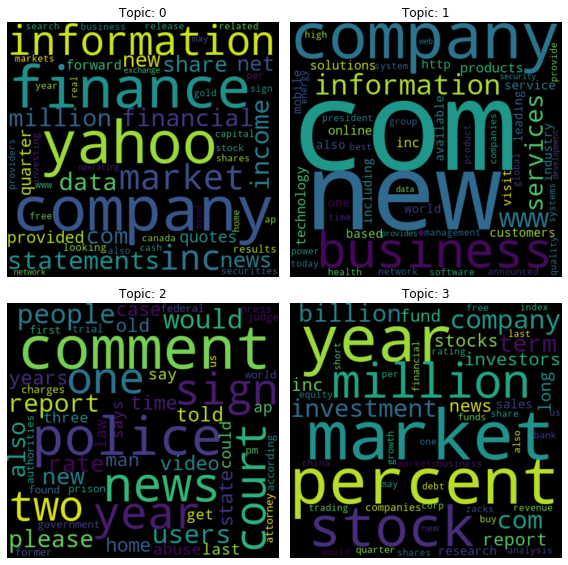

In [6]:
# Visualize topics 

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

num_top_words=50
f, axarr = plt.subplots(2, 2, figsize=(8, 8));

for topic_idx, topic in enumerate(lda.components_):
    # create a dataframe with two columns (word, weight) for each topic
    
    # create a word:count dictionary
    f={tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:num_top_words]}
    
    # generate wordcloud in subplots
    wordcloud = WordCloud(width=480, height=450, margin=0, background_color="black");
    _ = wordcloud.generate_from_frequencies(frequencies=f);
    
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].imshow(wordcloud, interpolation="bilinear");
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].set_title("Topic: "+str(topic_idx));
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].axis('off')

plt.tight_layout()
plt.show()


In [7]:
# Exercise 3.5. Assign documents to topic
import numpy as np
np.set_printoptions(suppress=True,precision=3)

# Generate topic assignment of each document
topic_assign=lda.transform(X_train)

# Show topic mixture for the first 6 documents
print(topic_assign[0:6])


[[0.029 0.904 0.001 0.066]
 [0.14  0.858 0.001 0.001]
 [0.107 0.819 0.001 0.073]
 [0.12  0.877 0.002 0.002]
 [0.002 0.052 0.944 0.002]
 [0.001 0.035 0.942 0.022]]


Questions:
- How to assign topics to each document?
- If your test data has been labeled, and you want to do external evaluation, how to calulate precision and recall?

In [8]:
# Exercise 3.6. Evaluate topic models by perplexity of test data

perplexity=lda.perplexity(X_test)
print("perplexity: {:.2f}".format(perplexity))


perplexity: 6048.43


## 4. Find the number of topics ($K$)
- There are no "golden" rules to find K.
- Perplexity may be one way for you to find the number of topics
    - Typically, the best number of topics should be around the **lowest perplexity**
- However, in practice, a few factors need to be considered:
  - It is usually difficult for human to understand or visulaize a big number of topics
  - You may manually scan the data to figure out possible topics in the data, but these topics may not be correlated with the hidden structure discovered by LDA
  - Usually, after LDA, we need manually inspect each discovered topic, merge or trim topics to get semantically coherent but distinguishable topics
- Some other tools you can try:
  - Loglikelihood (Griffiths & Steyvers, 2004)
  - Information divergence (Deveaud et al., 2014)
  - Average cosine distance of topics (Cao et al., 2009)
  - Symmetric K-L divergence (Arun et al., 2010)
    
<img src="ldatuning.png" width="50%" style="float: left;">

In [9]:
# Exercise 4.1 How to find the best number of topics?
# Vary variable num_topics, e.g. set it to 2, 3, 5, ...
# For each value, train LDA model, 
# calculate perplexity on the test data

import numpy as np
import matplotlib.pyplot as plt

result=[]
for num_topics in range(2,10):
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                learning_method='online', \
                                max_iter=30,verbose=0, n_jobs=1,
                                random_state=0).fit(X_train)
    p=lda.perplexity(X_test)
    result.append([num_topics,p])
    print(num_topics, p)



2 5623.2475192550355
3 5768.511781819806
4 5993.705468298306
5 6330.078732152989
6 6484.998048082893
7 6664.9582069943135
8 6941.262502138605
9 7054.48912259046


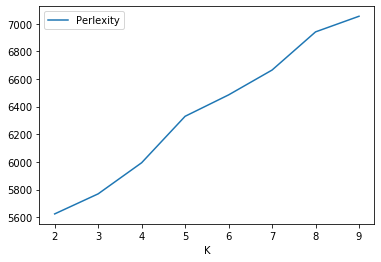

In [10]:
import pandas as pd
pd.DataFrame(result, columns=["K", "Perlexity"]).plot.line(x='K',y="Perlexity");
plt.show();

Discussion: With LDA, how to do internal evaluation?
- cluster separation
- cluster coherence

## 5. LDA Gensim Package

In [11]:
# 5.1. Create LDA model using the same TF matrix generated from sklearn

import gensim
from gensim import corpora

# A corpus is TF matrix in the list format, e.g.:
# [[(0, 1), (1,2), (4, 1), ...], [...], ...]
# which shows the first document has words with id=0,1,4
# and the count of word 0 is 1, word 1 is 2, ...

# convert the gensim corpus from the sparse tf matrix
corpus = gensim.matutils.Sparse2Corpus(X_train, \
                            documents_columns=False)

# create the mapping between id and words
id2word={idx:w for idx, w in \
         enumerate(tf_vectorizer.get_feature_names())}

# create a gensim dictionary from the corpus
# a dictionary contains the frequency of each words 
# the mapping between ids and words
dictionary = corpora.Dictionary.from_corpus(corpus, \
                            id2word=id2word)



In [12]:
# 6.2. Train LDA model

NUM_TOPICS = 4

# for detailed parameters, check
#https://radimrehurek.com/gensim/models/ldamodel.html

ldamodel = gensim.models.\
ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, \
                            id2word=id2word, \
                            iterations=30)

topics = ldamodel.print_topics(num_words=20)
for topic in topics:
    print(topic)
    print("\n")
    
# You may remove domain-specific stop words like 'said','company','com'. This may improve topics

(0, '0.006*"year" + 0.005*"company" + 0.005*"million" + 0.005*"new" + 0.004*"percent" + 0.004*"market" + 0.004*"com" + 0.004*"information" + 0.003*"inc" + 0.003*"also" + 0.003*"one" + 0.003*"quarter" + 0.003*"business" + 0.003*"mobile" + 0.002*"share" + 0.002*"billion" + 0.002*"www" + 0.002*"years" + 0.002*"sales" + 0.002*"power"')


(1, '0.005*"year" + 0.005*"police" + 0.005*"new" + 0.004*"one" + 0.004*"company" + 0.003*"also" + 0.003*"com" + 0.003*"two" + 0.003*"years" + 0.003*"people" + 0.002*"court" + 0.002*"business" + 0.002*"time" + 0.002*"would" + 0.002*"income" + 0.002*"information" + 0.002*"million" + 0.002*"first" + 0.002*"three" + 0.002*"old"')


(2, '0.009*"company" + 0.008*"com" + 0.007*"market" + 0.006*"inc" + 0.005*"news" + 0.005*"information" + 0.005*"finance" + 0.005*"business" + 0.005*"yahoo" + 0.004*"www" + 0.004*"stock" + 0.004*"new" + 0.004*"data" + 0.004*"financial" + 0.003*"million" + 0.003*"free" + 0.003*"term" + 0.003*"statements" + 0.003*"quarter" + 0.003*"sha

In [13]:
# 6.3. visualize topics
import pyLDAvis
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=True, R=20)
pyLDAvis.display(lda_display)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [14]:
# 6.4. Test unseen documents

test_corpus = gensim.matutils.Sparse2Corpus(X_test, \
                    documents_columns=False)
predict = ldamodel.get_document_topics(test_corpus)
list(predict)[0:5]

[[(0, 0.8535173), (2, 0.14440614)],
 [(0, 0.23471299), (1, 0.5779765), (2, 0.059490792), (3, 0.12781975)],
 [(0, 0.55630773), (1, 0.27846977), (2, 0.16091134)],
 [(1, 0.9551014), (3, 0.041524183)],
 [(1, 0.17863326), (3, 0.8182278)]]